In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_dir = "/home/angps/Documents/Thesis/Data/"
image_dir = "/home/angps/Documents/Thesis/Report/Images/"

In [13]:
df_atleast_50_cts = pd.read_csv(data_dir + 'data_>=50cts.csv').T
full_df = pd.read_csv(data_dir + 'df_>=1cts.csv').T
cluster_df = pd.read_csv(data_dir + 'cluster_df.csv').T.iloc[1:,:]

In [14]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [17]:
train_df = cluster_df.iloc[:,0:198]
test_df = cluster_df.iloc[:,198:]

In [18]:
train_df.shape

(9, 198)

In [20]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
Cluster_1_demand,0,2,1,0,3,2,0,1,2,1,...,1,5,4,2,0,0,2,5,2,6
Cluster_2_demand,0,2,3,3,8,4,1,0,0,2,...,3,1,17,4,0,0,1,3,1,3
Cluster_3_demand,1,0,3,1,1,1,3,0,4,3,...,1,0,0,1,3,3,4,2,0,0
Cluster_4_demand,6,0,12,17,4,0,7,2,13,10,...,5,2,0,0,1,1,3,2,4,0
Cluster_5_demand,0,15,7,15,17,9,0,17,11,18,...,7,26,8,2,1,6,22,25,4,5


In [21]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df

#grangers_causation_matrix(df_atleast_50_cts, variables = df_atleast_50_cts.columns)        

In [24]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [25]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    return True if p_value <= signif else False

In [28]:
res = []
for name, column in cluster_df.T.iteritems():
    res.append(adfuller_test(column, name=column.name))
    print('\n')


    Augmented Dickey-Fuller Test on "Cluster_1_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1754
 No. Lags Chosen       = 12
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.2153. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Cluster_2_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5453
 No. Lags Chosen       = 11
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0069. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cluster_3_demand" 
    -----------------------------------------------
 Null Hypothesis: 

In [33]:
cluster_diff = cluster_df.T.diff().dropna().T
cluster_diff

,1,2,3,4,5,6,7,8,9,10,...,194,195,196,197,198,199,200,201,202,203
Cluster_1_demand,2,-1,-1,3,-1,-2,1,1,-1,1,...,2,3,-3,4,-6,2,0,3,1,-3
Cluster_2_demand,2,1,0,5,-4,-3,-1,0,2,5,...,1,2,-2,2,-3,0,0,2,3,-2
Cluster_3_demand,-1,3,-2,0,0,2,-3,4,-1,-3,...,1,-2,-2,0,2,-2,3,-2,-1,0
Cluster_4_demand,-6,12,5,-13,-4,7,-5,11,-3,1,...,2,-1,2,-4,0,1,3,-2,-2,1
Cluster_5_demand,15,-8,8,2,-8,-9,17,-6,7,-7,...,16,3,-21,1,-4,10,0,2,-9,2
Cluster_6_demand,-5,3,15,-15,-3,12,-11,2,-1,-2,...,10,-6,-4,-3,2,3,4,-4,-3,-1
Cluster_7_demand,-3,0,-4,-5,-1,17,-1,-8,-2,-5,...,0,1,2,-4,1,-1,2,-1,0,-1
Cluster_8_demand,7,53,-31,-37,-8,20,8,52,-38,-31,...,19,-31,-8,-1,9,3,21,-26,-3,-6
Cluster_9_demand,14,13,-14,-10,-19,19,6,6,-7,-19,...,-1,-9,0,-7,10,-5,18,-18,-2,-6


In [35]:
res = []
for name, column in cluster_diff.T.iteritems():
    res.append(adfuller_test(column, name=column.name))
    print('\n')


    Augmented Dickey-Fuller Test on "Cluster_1_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5935
 No. Lags Chosen       = 11
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cluster_2_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0078
 No. Lags Chosen       = 10
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cluster_3_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

In [39]:
cluster_diff

,1,2,3,4,5,6,7,8,9,10,...,194,195,196,197,198,199,200,201,202,203
Cluster_1_demand,2,-1,-1,3,-1,-2,1,1,-1,1,...,2,3,-3,4,-6,2,0,3,1,-3
Cluster_2_demand,2,1,0,5,-4,-3,-1,0,2,5,...,1,2,-2,2,-3,0,0,2,3,-2
Cluster_3_demand,-1,3,-2,0,0,2,-3,4,-1,-3,...,1,-2,-2,0,2,-2,3,-2,-1,0
Cluster_4_demand,-6,12,5,-13,-4,7,-5,11,-3,1,...,2,-1,2,-4,0,1,3,-2,-2,1
Cluster_5_demand,15,-8,8,2,-8,-9,17,-6,7,-7,...,16,3,-21,1,-4,10,0,2,-9,2
Cluster_6_demand,-5,3,15,-15,-3,12,-11,2,-1,-2,...,10,-6,-4,-3,2,3,4,-4,-3,-1
Cluster_7_demand,-3,0,-4,-5,-1,17,-1,-8,-2,-5,...,0,1,2,-4,1,-1,2,-1,0,-1
Cluster_8_demand,7,53,-31,-37,-8,20,8,52,-38,-31,...,19,-31,-8,-1,9,3,21,-26,-3,-6
Cluster_9_demand,14,13,-14,-10,-19,19,6,6,-7,-19,...,-1,-9,0,-7,10,-5,18,-18,-2,-6


In [44]:
np.asarray(cluster_diff.T)

array([[2, 2, -1, ..., -3, 7, 14],
       [-1, 1, 3, ..., 0, 53, 13],
       [-1, 0, -2, ..., -4, -31, -14],
       ...,
       [3, 2, -2, ..., -1, -26, -18],
       [1, 3, -1, ..., 0, -3, -2],
       [-3, -2, 0, ..., -1, -6, -6]], dtype=object)

In [47]:
from statsmodels.tsa.api import VAR
#model = VAR(train_df)
model = VAR(np.asarray(cluster_diff.T))
#model.select_order().selected_orders

In [48]:
result = model.fit(maxlags=12)
result.summary()

AttributeError: 'float' object has no attribute 'sqrt'

In [ ]:
for i in [1,2]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [44]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,31.00,31.15,2.904e+13,31.06
1,26.64,28.16*,3.704e+11,27.26*
2,26.77,29.67,4.255e+11,27.95
3,26.97,31.24,5.239e+11,28.70
4,26.84,32.49,4.727e+11,29.13
5,26.71,33.74,4.349e+11,29.56
6,26.35,34.74,3.209e+11,29.75
7,26.12,35.89,2.791e+11,30.07
8,26.19,37.33,3.391e+11,30.70
9,26.45,38.97,5.191e+11,31.52


In [45]:
model_fitted = model.fit(2)
#model_fitted.summary()

In [46]:
def adjust(val, length= 6): 
    return str(val).ljust(length)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(train_df.columns, out):
    print(adjust(col), ':', round(val, 2))

0      : 1.94
1      : 1.96
2      : 1.96
3      : 2.04
4      : 1.97
5      : 1.98
6      : 1.95
7      : 1.91
8      : 2.01


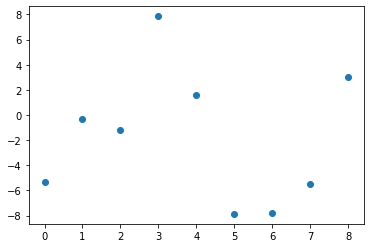

In [47]:
plt.scatter(range(len(model_fitted.resid.values[5])), model_fitted.resid.values[5])

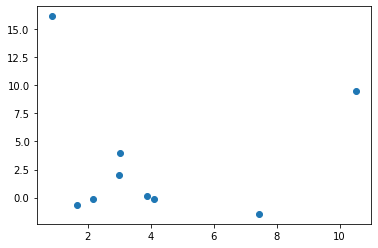

In [48]:
plt.scatter(model_fitted.fittedvalues.values[2], model_fitted.resid.values[2])

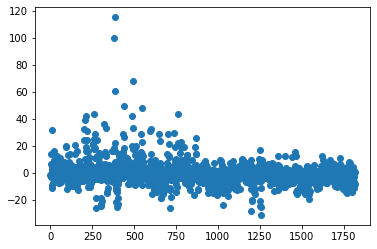

In [49]:
plt.scatter(range(len(model_fitted.resid.values.flatten())), model_fitted.resid.values.flatten())

(array([2.400e+01, 5.630e+02, 1.145e+03, 6.100e+01, 1.700e+01, 4.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-31.20801638, -16.55800456,  -1.90799274,  12.74201908,
         27.39203089,  42.04204271,  56.69205453,  71.34206634,
         85.99207816, 100.64208998, 115.2921018 ]),
 <a list of 10 Patch objects>)

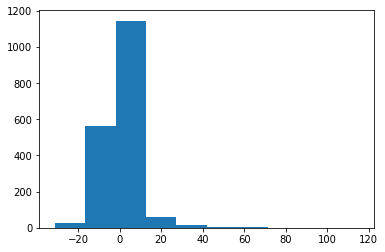

In [50]:
plt.hist(model_fitted.resid.values.flatten())

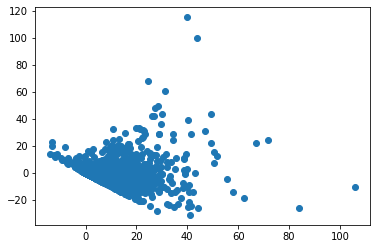

In [51]:
plt.scatter(model_fitted.fittedvalues.values.flatten(), model_fitted.resid.values.flatten())

In [52]:
forecast_input = train_df.values[-2:]
forecast_input

array([[1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [53]:
df_atleast_50_cts.shape

(204, 42)

In [54]:
df_atleast_50_cts.columns = [str(i) for i in range(42)]
df_atleast_50_cts.columns 

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41'],
      dtype='object')

In [ ]:
fc = model_fitted.forecast(y=forecast_input, steps=6)
df_forecast = pd.DataFrame(fc, index=df_atleast_50_cts.index[-6:], columns=df_atleast_50_cts.columns + '_1d')
df_forecast

In [ ]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_df, df_forecast) 

In [ ]:
def compute_errors(pred, act):
    err = np.square(np.subtract(pred, act)).sum()
    return err

In [ ]:
act = df_atleast_50_cts.iloc[198:,:].values
act.shape

In [ ]:
pred = df_results.iloc[:,42:].values
pred.shape

In [ ]:
loss = []
fitted = []
SFE = 0
for i in range(len(act)):
    forecast = fc[i]
    actual = pred[i]
    loss.extend(forecast-actual)
    forecast_err = compute_errors(forecast, actual)
    #forecast_err = compute_errors(forecast, train)
    SFE += forecast_err
print("MSFE for VAR model on subset of dataset: " + str(round(SFE/6, 3)))

In [55]:
model_fitted.is_stable()

True

In [56]:
model_fitted.test_normality().summary()

Test statistic,Critical value,p-value,df
6126.,28.87,0.000,18


In [57]:
model_fitted.test_whiteness().summary()

Test statistic,Critical value,p-value,df
835.9,708.3,0.000,648
